Author: Peizhong Ju

Date: June 2024

Description: DDPM demo on synthetic data (drawing parabolas)

In [1]:
%config InlineBackend.figure_format = 'svg' # use vector graphics for figures
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True # use LaTeX for typesetting
import os

# set the random seed for reproducibility
torch.manual_seed(0)
# set the device to GPU if available, otherwise use CPU
device = (
    torch.device(f"cuda:{torch.cuda.current_device()}")
    if torch.cuda.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using device: {device}")
if device != "cpu":
    print(f"Device name: {torch.cuda.get_device_name()}")

Using device: cpu


Now let's generate some data for the regression task. 

We will generate $n$ different parabolas whose domain is fixed in $[-5, 5]$.
Each parabola is described by the values on the domain.

The corresponding value of each sample is $f(r) = a_0 + a_1  r + a_2  r^2$, 
where $r$ is a value in the $[-5, 5]$ with resolution $0.2$. 

To generate one sample, we first randomly choose a $3$-element vector $[a_0, a_1, a_2]$,
where $a_0$, $a_1$, $a_2$ are *i.i.d.* uniformly sampled from $[-1, 1]$.
And then calculate the corresponding value $f(r)$ for each $r$ in the $[-5, 5]$ with resolution $0.2$.
The value of $f(r)$ is stored in a tensor $X$ of shape $(d, 1)$, where $d$ is the number of $r$ values.

We will generate n samples, and store them in a tensor $X$ of shape $(n, d)$.




In [2]:
# Generate r value in [-5, 5] with resolution 0.2
r = torch.arange(-5, 5, 0.2).view(-1, 1)
# number of samples n
n = 600
# for each sample, generate a 3-element vector [a_0, a_1, a_2], each element is uniformly sampled from [-1, 1]
a = torch.rand(n, 3) * 2 - 1
# calculate the corresponding value f(r) = a_0 + a_1 * r + a_2 * r^2, element-wise of r
# store the result in X, each column of X is the f(r) of a sample
X = a[:, 0] + a[:, 1] * r + a[:, 2] * r**2
# dimension of each sample
d = X.shape[0]


We will then plot the first $4$ samples of the data $X$, each in a different color, and mark the values of $a$ in the legend.

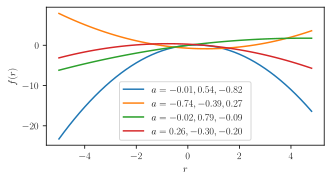

In [3]:
# show plot of the first 4 sample, in 4 different colors, mark the values of a (keep 2 digits) in the legend
plt.rcParams['figure.figsize'] = [5, 2.5]
plt.plot(r, X[:, :4])
plt.legend([f"$a={a[i, 0]:.2f}, {a[i, 1]:.2f}, {a[i, 2]:.2f}$" for i in range(4)])
plt.xlabel("$r$")
plt.ylabel("$f(r)$")
plt.show()

Let's define some constants of the diffusion process.

$T$: number of steps

$\beta_t$: variance schedule

$\alpha_t:=1-\beta_t$

$\bar{\alpha}_t:=\prod_{s=1}^t \alpha_s$

In [4]:
T = 100
# set the value of beta, beta_1 = 10^-4, beta_T = 0.02, linearly interpolate the values in between
beta = torch.linspace(1e-4, 0.02, T)
# calculate the value of alpha, alpha_t = 1 - beta_t
alpha = 1 - beta
# calculate alpha_bar by the product of alpha_t from t=1 to T
alpha_bar = alpha.cumprod(dim=0)

## Model

We now define the model.

### Functionality

Distill the noise component out of a noisy sample of step $t$. Notice that the output is the noise, not the de-noised sample.

### Input

The input of the model includes two elements, a vector and a scalar.

The vector is $x_t$ (d-dim vector).

The scalar is the index of the step $t$.

The input $x_t$ can be regarded as the noisy version of a sample. As we will show later, during the training, $x_t$ is constructed by $\sqrt{\bar{\alpha}_t}\cdot  x_0 + \sqrt{1 - \bar{\alpha}_t}\cdot  \epsilon$, where $x_0$ is the original sample and $\epsilon$ is the manually generated noise.

### Output

The output $\epsilon_{\theta}$ is the prediction of the noise vector $\epsilon$, whose dimension is same as $x_t$.

In [5]:
# define the model
from model import Model
model = Model(input_size=d, hidden_size=400, embedding_size=20, T=T)

## Generating (reverse process)

The reverse process goes from T to 0 step by step.

At $t=T$, the sample is pure noise.

At each step from $t$ to $t-1$, the reverse process will remove a little noise $\epsilon_{\theta}(x_t,t)$ out of the noisy sample $x_t$ and then add some variance $\sigma_t z$ to get a cleaner sample $x_{t-1}$. Specifically, the update is described by 
$$\sigma_t\gets\sqrt{\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t},$$

$$z\sim \mathcal{N}(0,I)\ \text{ if }\ t>1\ \text{ else }\ z=0,$$

$$x_{t-1}\gets \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t }{\sqrt{1-\bar{\alpha}_t}}\right)+\sigma_t z.$$
Here $\epsilon_{\theta}(x_t,t)$ is the **model** we just defined that gives the noise component of $x_t$.

In [6]:
def reverse_process(_num=1, return_all=False):
    # generate samples by the reverse process of DDPM
    # _num is the number of samples to generate
    # return_all is a flag to indicate whether to return all intermediate samples
    curr_x = torch.randn(_num, d) # start from pure noise
    if return_all:
        all_x = [curr_x.clone()]
    # from T to 0
    for t in range(T - 1, -1, -1):
        # calculate the noise vector by the model
        curr_noise_by_model = model(curr_x, torch.tensor([t] * _num))
        # calculate the variance part
        if t > 0:
            z = torch.randn(_num, d)
            z *= torch.sqrt((1 - alpha_bar[t - 1]) * beta[t] / (1 - alpha_bar[t]))
        else:
            z = torch.zeros(_num, d)
        # update curr_x
        curr_x = (
            curr_x - beta[t] / torch.sqrt(1 - alpha_bar[t]) * curr_noise_by_model
        ) / torch.sqrt(alpha[t]) + z
        if return_all:
            all_x.append(curr_x.clone())
    if return_all:
        return all_x
    return curr_x.T

## Performance metrics

Before we start training the model, we need to define some performance metrics. We will evaluate the performance from two aspects: precision and distribution.

### Precision

For each generated sample, we want to check how much it looks like an actual parabola. To achieve this goal, we first find the closest parabola and then calculate the distance away from it. We use $\ell_2$-norm distance to measure the difference between two $d$-dim vectors. This leads to a simple linear regression. Let $\odot$ denote the element-wise product. The design matrix here is
\begin{equation*}
    R = \begin{bmatrix}
1 & r &r\odot r
\end{bmatrix}
\quad (\text{dimension: }d\times 3).
\end{equation*}
To find the closest parabola to the sample $x$, we solve the following regression
\begin{equation*}
\min_{a_0,a_1,a_2}\left\|x - 
R
\begin{bmatrix}
a_0\\
a_1\\
a_2
\end{bmatrix}\right\|^2.
\end{equation*}
The solution value is the squared distance to the closest parabola, which is a measure of precision (smaller is better) 

The minimizer to that regression is
\begin{equation*}
\begin{bmatrix}
a_0^*\\
a_1^*\\
a_2^*
\end{bmatrix}=(R^T R)^{-1} R^T x.
\end{equation*}
Details about the formula of this minimizer can be found at, e.g., [Wikipedia: linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares).

### Distribution

Besides precision, we still want the generated samples to be **diverse**. 

To measure the diversity of the generated samples, we check the difference between the distribution of the generated samples and the ground truth. Since the parabolas can be represented by the coefficients $a_0$, $a_1$, and $a_2$, we just check the distribution difference of each one of these coefficients. 

Here, we use Kolmogorov–Smirnov test (**KS test**) to quantify the distribution difference. In short, in KS test, we calculate the largest gap between the empirical CDF and the ground-truth CDF. See more info at [Wikipedia: Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

In [7]:

def fit_by_a_parabola(_y):
    # given the samples, fit the samples by a parabola
    # _y has the shape of [d, test_num]
    _X = torch.cat([r, r**2], dim=1)
    # append 1 to the beginning of each row of _X
    _X = torch.cat([torch.ones_like(_X[:, :1]), _X], dim=1)
    param = torch.inverse(_X.T @ _X) @ _X.T @ _y
    err = torch.mean((_X @ param - _y) ** 2)
    return param, err

def get_KS_statistic_and_err(_y, plot=False):
    _, _num = _y.shape
    all_params, err = fit_by_a_parabola(_y)
    # check the coverage of the fitted parabola
    # use KS test to check the distribution of the fitted parabola
    # check each parameter one by one
    KS_statistic = torch.zeros(3)
    for i in range(3):
        a = all_params[i]
        # sort the parameter
        a, _ = torch.sort(a)
        # and calculate the KS statistic with respect to the uniform distribution in [-1, 1]
        temp = torch.arange(1, _num + 1) / _num
        KS_statistic[i] = torch.max(torch.abs(temp - a / 2 - 0.5))
        if plot:
            plt.plot(a.cpu(), temp.cpu(), label=f"Parameter {i}")
    if plot:
        plt.legend()
        plt.show()
    return err, KS_statistic

def test_error(plot=False):
    with torch.no_grad():
        test_num = 2000
        samples = reverse_process(test_num)
        return get_KS_statistic_and_err(samples, plot)

## Training

For each epoch, we will do the following steps:

1. Go through the randomly shuffled dataset, batch by batch.
2. Go through $1$ to $T$ in a random order.
3. For the current $t$ and the batch of samples $X$, we construct $x_t$ by incorporating Gaussian noise vector $\epsilon$ (newly generated for every sample and loop):
   $$X_t \gets \sqrt{\bar{\alpha}_t}X + \sqrt{1-\bar{\alpha}_t} \epsilon.$$
4. Calculate the loss by comparing $\epsilon$ and the model output $\epsilon_{\theta}(X_t, t)$.
5. Do gradient descent on the loss.

In [8]:
# define the function to train the model
def train_the_model():
    # training the model
    # repeat for some epochs
    epochs = 200
    # define the optimizer, Adam optimizer
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # define the loss function, mean squared error
    criterion = nn.MSELoss()

    # before training, just print the configuration of the simulation
    print(f"Number of samples: {n}")
    print(f"Dimension of each sample: {d}")
    print(f"Number of time steps: {T}")
    print(f"Embedding size: {model.embedding.embedding_dim}")
    print(f"Number of epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss function: Mean Squared Error")
    print(f"Optimizer: Adam")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

    start_time = time.time()
    # for each epoch
    for epoch in range(epochs):
        # shuffle the samples
        _X = X[:, torch.randperm(n)]
        # '''
        # split the samples into batches
        batch_size = 200
        # for each batch
        for i in range(0, n, batch_size):
            # define a variable to store the loss
            sum_loss = 0
            # generate a random permutation of 0 to T-1
            for t in torch.randperm(T):
                # for each time step
                # generate the target, which is the noise vector epsilon_theta
                target = torch.randn(d, batch_size)
                # generate the input x_t, x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon_theta
                x_t = (
                    torch.sqrt(alpha_bar[t]) * _X[:, i : i + batch_size]
                    + torch.sqrt(1 - alpha_bar[t]) * target
                )
                # calculate the prediction of the noise vector epsilon by the model
                output = model(x_t.T, torch.tensor([t] * batch_size))
                # calculate the loss
                loss = criterion(output, target.T)
                # back propagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                sum_loss += loss.item()
            # average the loss
            loss = sum_loss / T

        if epoch % 10 == 0:
            # calculate the error
            err = test_error()
            print(
                f"Epoch {epoch}, Loss: {loss:.4f}, Test Error: {err[0]:.4f}, KS: {torch.mean(err[1]):.4f}, Elapsed time: {time.time() - start_time:.2f} seconds"
            )

## Execute, Save/Load

In [9]:
# flag to determine whether to train the model or load the model
# if train_model is True, train the model
# if train_model is False, load the model
train_model = True
# train_model = False
# get the current directory
curr_dir = os.path.abspath("")
# model path to save the model
# model_path = os.path.join(curr_dir, "model.pth")
model_path = os.path.join(curr_dir, "model_temp.pth")
if not train_model:
    # load the model
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    # train and save the model
    train_the_model()
    torch.save(model.state_dict(), model_path)

Number of samples: 600
Dimension of each sample: 50
Number of time steps: 100
Embedding size: 20
Number of epochs: 200
Learning rate: 0.001
Loss function: Mean Squared Error
Optimizer: Adam
Number of parameters: 679320
Epoch 0, Loss: 0.5598, Test Error: 0.4336, KS: 0.3507, Elapsed time: 5.71 seconds
Epoch 10, Loss: 0.1923, Test Error: 0.0160, KS: 0.3535, Elapsed time: 32.62 seconds
Epoch 20, Loss: 0.1564, Test Error: 0.0066, KS: 0.3285, Elapsed time: 57.96 seconds
Epoch 30, Loss: 0.1543, Test Error: 0.0051, KS: 0.3553, Elapsed time: 83.24 seconds
Epoch 40, Loss: 0.1423, Test Error: 0.0026, KS: 0.3702, Elapsed time: 108.55 seconds
Epoch 50, Loss: 0.1359, Test Error: 0.0024, KS: 0.3356, Elapsed time: 135.40 seconds
Epoch 60, Loss: 0.1340, Test Error: 0.0055, KS: 0.3525, Elapsed time: 161.26 seconds
Epoch 70, Loss: 0.1406, Test Error: 0.0041, KS: 0.3594, Elapsed time: 187.01 seconds
Epoch 80, Loss: 0.1423, Test Error: 0.0015, KS: 0.3284, Elapsed time: 212.87 seconds
Epoch 90, Loss: 0.1200

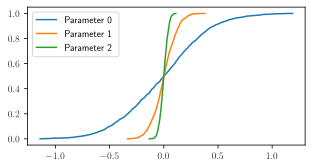

(tensor(0.0006), tensor([0.1725, 0.3740, 0.4503]))


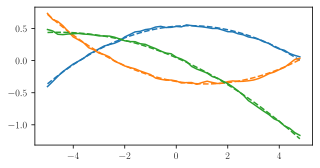

In [10]:

# test the model
# calculate the error
# get_KS_statistic_and_err(X, plot=True)
err = test_error(plot=True)
print(err)

# generate 3 samples and plot them
import matplotlib as mpl
color_cycler = iter(mpl.rcParams['axes.prop_cycle'])
samples = reverse_process(3)
aa, err = fit_by_a_parabola(samples)
torch.set_default_device('cpu')
for _ in range(3):
    # choose the line color in sequence
    line_color = next(color_cycler)['color']
    sample = samples[:, _].cpu().detach().numpy()
    a = aa[:, _].cpu().detach().numpy()
    r = r.cpu()
    fitted_parabola = a[0] + a[1] * r + a[2] * r**2
    # plot the sample and the fitted parabola, one is the solid line, the other is the dashed line
    plt.plot(r, sample, color=line_color)
    plt.plot(r, fitted_parabola, linestyle="--", color=line_color)
plt.show()


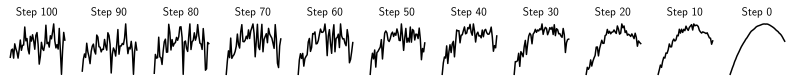

In [11]:
torch.manual_seed(1)
all_x = reverse_process(return_all=True)
# subplot the samples at different time steps in a 1x10 row
plt.rcParams['figure.figsize'] = [14, 1]
for i in range(0, T+1, 10):
    plt.subplot(1, 11, i // 10 + 1)
    plt.plot(r, all_x[i].T.cpu().detach().numpy(), color="black")
    plt.title(f"Step {T-i}")
    plt.axis("off")
plt.savefig("samples.png", bbox_inches="tight")